# Normalize by Internal Standard Quantification

Lexi Jones-Kellett

Date created: 11/16/22
    
Last edited: 07/17/23


Testing code to calculate the absolute abundance of an ASV based on internal standard reads. Code was applied to the whole dataset with "calc_ASV_abundance_from_IS_v2.py".

In [1]:
import csv,math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime

In [2]:
# Plot params
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

### Get the ASV reads for the internal standards (IS)

BP: d__Bacteria; p__Firmicutes; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__Blautia; s__Blautia_producta 

    NOTE: There are 3 'Blautia' OTUs in the data, there may be 5 ASVs

DR: d__Bacteria; p__Deinococcota; c__Deinococci; o__Deinococcales; f__Deinococcaceae; g__Deinococcus; s__Deinococcus_radiodurans


TT: d__Bacteria; p__Deinococcota; c__Deinococci; o__Thermales; f__Thermaceae; g__Thermus; s__Thermus_thermophilus'
    
    NOTE: There are 2 'Thermus_thermophilus' OTUs in the data

In [3]:
BP_OTUID1,BP_OTUID2,BP_OTUID3 = '0a1e7e4b25a59be69931c5d7f92751f5','f40b1be49d3bca5b8fabdd944abb31bf','2029a1010d7bebac2d09361c275f9fda'
DR_OTUID = '6a5fcf5f0ca1f18bca2297194442a6d7'
TT_OTUID1,TT_OTUID2 = '9aa3ebacc998945a0cd514ca909e5231','5b0d64b13238ee1991c15a9913bec9bc'

Using corrected 16S + 18S merged table to get the reads

In [4]:
ASV_count_dir = '/Users/lexijones/Dropbox (MIT)/Grad_School/Research/G4_consolidated/data/HighCoverage_221107/merged_16S_18S_tables/'
ASV_count_file = '221118-1309_LexiGradients-HighCov_2.09-fold-18S-correction_normalized_sequence_counts.tsv'

BP_data,DR_data,TT_data = [],[],[]
with open(ASV_count_dir + ASV_count_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    c = 0
    for row in csv_reader:
        if c == 0:
            header = row[1:-1]
            print(header)
        else:
            OTU = row[0]
            if (OTU == BP_OTUID1) or (OTU == BP_OTUID2) or (OTU == BP_OTUID3):
                BP_data.append([float(r) for r in row[1:-1]]) # exclude OTU and taxonomy  
            elif (OTU == DR_OTUID):
                DR_data.append([float(r) for r in row[1:-1]])
            elif (OTU == TT_OTUID1) or (OTU == TT_OTUID2):
                TT_data.append([float(r) for r in row[1:-1]])
        c +=1 
        
print(len(BP_data))
print(len(DR_data))
print(len(TT_data))

['10A', '10B', '10C', '11A', '11B', '11C', '12A', '13A', '13B', '13C', '14A', '14B', '14C', '15B', '15C', '16A', '16B', '16C', '16s-even-1', '16S-even-2', '16S-even-3', '16s-mock-even-insilico-v2', '16s-mock-staggered-insilico-v2', '16s-stag-1', '16S-stag-2', '17A', '17B', '17C', '18A', '18B', '18C', '18s-even-1', '18S-even-2', '18s-mock-even-insilico', '18s-mock-staggered-insilico', '18S-stag-1', '18S-stag-2', '19A', '19B', '19C', '20Ai', '20Aii', '20B', '20C', '21A', '21B', '21C', '22A', '22B', '22C', '23A', '23B', '23C', '24A', '24B', '24C', '25A', '25B', '25C', '26A', '26B', '26C', '27A', '27B', '27C', '28A', '28B', '28C', '29A', '29B', '29C', '30A', '30B', '30C', '31A', '31B', '31C', '32A', '32B', '32C', '33A', '33B', '33C', '34A', '34B', '34C', '35A', '35B', '35C', '36A', '36B', '36C', '36Cv2', '37A', '37B', '38A', '38C', '38Cv2', '39A', '39B', '39C', '39Cv2', '3A', '3B', '3C', '40A', '40B', '40C', '41A', '41B', '41C', '41Cv2', '44A', '44B', '44C', '44Cv2', '44RA', '44RB', '44RC'

Sum the counts for the IS with multiple OTUs

In [5]:
BP_count = np.sum(BP_data,axis=0)
DR_count = np.array(DR_data)[0]
TT_count = np.sum(TT_data,axis=0)

print(np.shape(BP_count))
print(np.shape(DR_count))
print(np.shape(TT_count))

(244,)
(244,)
(244,)


### QC: Check counts in control samples

Would expect these to be close to 0

In [6]:
np.array(header)[np.where([i==0 for i in BP_count])[0]]

array(['12A', '16s-even-1', '16S-even-2', '16S-even-3',
       '16s-mock-even-insilico-v2', '16s-mock-staggered-insilico-v2',
       '16S-stag-2', '18s-even-1', '18S-even-2', '18s-mock-even-insilico',
       '18s-mock-staggered-insilico', '18S-stag-2', 'MQ12', 'PCR-blank-1',
       'PCR-blank-10', 'PCR-blank-2', 'PCR-blank-3', 'PCR-blank-4',
       'PCR-blank-5', 'PCR-blank-6', 'PCR-blank-7', 'PCR-blank-8'],
      dtype='<U30')

In [7]:
#These were expected to be =0
print(BP_count[np.where([i=='PCR-blank-9' for i in np.array(header)])])
print(BP_count[np.where([i=='16s-stag-1' for i in np.array(header)])])
print(BP_count[np.where([i=='18S-stag-1' for i in np.array(header)])])
print(BP_count[np.where([i=='Blank' for i in np.array(header)])])
print(BP_count[np.where([i=='LB' for i in np.array(header)])])

[14.15730337]
[5.31095567]
[6.56842105]
[465.13076298]
[9.74722162]


In [8]:
np.array(header)[np.where([i==0 for i in DR_count])[0]]

array(['12A', '16s-even-1', '16S-even-2', '16s-mock-even-insilico-v2',
       '16s-mock-staggered-insilico-v2', '16s-stag-1', '16S-stag-2',
       '18S-even-2', '18s-mock-even-insilico',
       '18s-mock-staggered-insilico', '18S-stag-1', 'LB', 'PCR-blank-1',
       'PCR-blank-10', 'PCR-blank-2', 'PCR-blank-4', 'PCR-blank-5',
       'PCR-blank-6', 'PCR-blank-7', 'PCR-blank-8', 'PCR-blank-9'],
      dtype='<U30')

In [9]:
print(DR_count[np.where([i=='16S-even-3' for i in np.array(header)])])
print(DR_count[np.where([i=='18s-even-1' for i in np.array(header)])])
print(DR_count[np.where([i=='18S-stag-2' for i in np.array(header)])])
print(DR_count[np.where([i=='PCR-blank-3' for i in np.array(header)])])
print(DR_count[np.where([i=='MQ12' for i in np.array(header)])])
print(DR_count[np.where([i=='Blank' for i in np.array(header)])])

[2.11942222]
[7.23287671]
[6.16304348]
[5.28426396]
[3.28337808]
[274.89997812]


In [10]:
np.array(header)[np.where([i==0 for i in TT_count])[0]]

array(['12A', '16s-even-1', '16S-even-2', '16s-mock-even-insilico-v2',
       '16s-mock-staggered-insilico-v2', '16S-stag-2', '18S-even-2',
       '18s-mock-even-insilico', '18s-mock-staggered-insilico',
       '18S-stag-1', '18S-stag-2', 'PCR-blank-10', 'PCR-blank-2',
       'PCR-blank-4', 'PCR-blank-5', 'PCR-blank-6', 'PCR-blank-7',
       'PCR-blank-8', 'PCR-blank-9'], dtype='<U30')

In [11]:
print(TT_count[np.where([i=='16s-stag-1' for i in np.array(header)])])
print(TT_count[np.where([i=='18s-even-1' for i in np.array(header)])])
print(TT_count[np.where([i=='PCR-blank-1' for i in np.array(header)])])
print(TT_count[np.where([i=='PCR-blank-3' for i in np.array(header)])])
print(TT_count[np.where([i=='MQ12' for i in np.array(header)])])
print(TT_count[np.where([i=='Blank' for i in np.array(header)])])
print(TT_count[np.where([i=='LB' for i in np.array(header)])])

[4.24876454]
[10.84931507]
[3.32467532]
[7.04568528]
[7.66121552]
[471.72836245]
[43.32098496]


Note: The 'Blank' samples had highest reads

### Internal standards conversion

"absolute" abundance of ASV = (reads of ASV * total # of 16S rRNA spiked from IS) / (reads of IS * vol of filtered seawater)

In [12]:
BP_genome_len,DR_genome_len,TT_genome_len = 6244976,3279485,2143708 #[bp]
BP_rrn,DR_rrn,TT_rrn = 5,3,2 #[16S rRNA copy#/cell]

In [13]:
def calc_IS_Cs(genome_len,rrn,conc):
    """
    Inputs
        genome_len: genome length [bp]
        rrn: copy number of 16S rRNA per cell
        conc: concentration of DNA from quantification, batch specific [ng/muL]
    Output
        CS:
    """
    AgC = 6.022*(10**23) #Avogadro's constant [copies/mol]
    bp_weight = 650 #[g/(mol*bp)]
    CF = 10**9 #[ng/g]
    vol_IS = 20 #[muL]
    
    return (conc*vol_IS*AgC*rrn)/(genome_len*CF*bp_weight)

The DNA concentation (conc in `calc_IS_Cs()`) will depend on which batch the sample was a part of.

In [14]:
IS_file = '/Users/lexijones/Dropbox (MIT)/Grad_School/Research/G4_consolidated/data/IS_quants.csv' # table made in script "internal_standards_quant.ipynb"

IS_quants = {}
with open(IS_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row)
        else:
            IS_quants[int(row[0])] = [float(j) for j in row[1:]]
        i += 1
IS_quants

['batch', 'bp(ng/muL)', 'dr(ng/muL)', 'tt(ng/muL)']


{1: [0.169154522, 0.157473115, 0.2390493515],
 2: [0.1705743615, 0.150502993, 0.2507307585],
 3: [0.171994201, 0.1315933115, 0.2362742105],
 4: [0.1785125555, 0.144500944, 0.239242966],
 5: [0.188967738, 0.132496846, 0.218590754],
 6: [0.1760601055, 0.138305281, 0.21955882599999998],
 7: [0.172187816, 0.15250367650000002, 0.2435670225],
 8: [0.170832514, 0.12797917450000001, 0.2260771805],
 9: [0.171994201, 0.1273337935, 0.24453509499999998],
 10: [0.1629588585, 0.14850231, 0.220075132],
 11: [0.159990103, 0.148695925, 0.2152347695],
 12: [0.1620553245, 0.129463553, 0.20258529]}

### Calculate Cs for each batch and IS

In [15]:
#format: [BP,DR,TT]
Cs = {}
for key in IS_quants:
    BP_conc,DR_conc,TT_conc = IS_quants[key][0],IS_quants[key][1],IS_quants[key][2]
    Cs[key] = [calc_IS_Cs(BP_genome_len,BP_rrn,BP_conc),calc_IS_Cs(DR_genome_len,DR_rrn,DR_conc),calc_IS_Cs(TT_genome_len,TT_rrn,TT_conc)]
Cs

{1: [2509459.743157478, 2669189.5414535655, 4132466.361256721],
 2: [2530523.5020500408, 2551045.077587112, 4334403.8322297335],
 3: [2551587.2609426053, 2230523.5454384782, 4084492.264032515],
 4: [2648289.069537349, 2449309.5755105074, 4135813.3914966313],
 5: [2803394.941262815, 2245838.571357299, 3778796.855622271],
 6: [2611906.2139427075, 2344292.2912460105, 3795531.998178282],
 7: [2554459.599455503, 2584956.9200877114, 4210563.72199658],
 8: [2534353.2743711467, 2169263.4587133233, 3908215.3438262474],
 9: [2551587.2609426053, 2158324.167803551, 4227298.873196134],
 10: [2417545.1555273575, 2517133.243561577, 3804457.4236761006],
 11: [2373502.7478728495, 2520415.042699598, 3720781.667678333],
 12: [2404140.94869466, 2194423.865096079, 3502109.0455057668]}

In [21]:
batch_file = '/Users/lexijones/Dropbox (MIT)/Grad_School/Research/G4_consolidated/data/G4_IS_sample_batches.csv'
bad_samples = ['52C','49C','41C','51C','44C','36C','50C','39C','38C','46C','48C','45R']

sample_batches = {}
with open(batch_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for row in csv_reader:
        if (i==0) or (row[1] == 'MQ12') or (row[1] == 'LB') or (row[1] == 'Blank'): # these samples did not have internal standards added
            pass
        elif (row[0] == '2'): # we know there was an error with pipetting TT for this batch
            pass
        elif (row[1] in bad_samples): # samples that were zapped in UV, replaced with v2 samples
            pass
        elif (row[1] == 'B2M2'): # zooplankton sample
            pass
        else:
            sample_batches[row[1]] = int(row[0])
        i += 1

Put original number of reads into a dict

In [22]:
IS_reads = {} # key: [BP,DR,TT]
for i in np.arange(0,len(header)):
    IS_reads[header[i]] = [BP_count[i],DR_count[i],TT_count[i]]

Use batch number to get the IS concentration

In [23]:
IS_abundances = {} # key: [A_BP_IS_BP,A_DR_IS_BP,A_TT_IS_BP,
                    #          0          1         2                         
                    #     A_BP_IS_DR,A_DR_IS_DR,A_TT_IS_DR,
                    #          3          4         5                        
                    #     A_BP_IS_TT,A_DR_IS_TT,A_TT_IS_TT]
                    #          6          7         8      

vol_seawater = 1000 #mL
for key in sample_batches:
    BP_Cs,DR_Cs,TT_Cs = Cs[sample_batches[key]] 
    BP_reads,DR_reads,TT_reads = IS_reads[key]
        
    # Abundances with BP as the IS
    A_BP_IS_BP = (BP_reads*BP_Cs)/(BP_reads*vol_seawater)
    A_DR_IS_BP = (DR_reads*BP_Cs)/(BP_reads*vol_seawater)
    A_TT_IS_BP = (TT_reads*BP_Cs)/(BP_reads*vol_seawater)
        
    # Abundances with DR as the IS
    A_BP_IS_DR = (BP_reads*DR_Cs)/(DR_reads*vol_seawater)
    A_DR_IS_DR = (DR_reads*DR_Cs)/(DR_reads*vol_seawater)
    A_TT_IS_DR = (TT_reads*DR_Cs)/(DR_reads*vol_seawater)
        
    # Abundances with TT as the IS
    A_BP_IS_TT = (BP_reads*TT_Cs)/(TT_reads*vol_seawater)
    A_DR_IS_TT = (DR_reads*TT_Cs)/(TT_reads*vol_seawater)
    A_TT_IS_TT = (TT_reads*TT_Cs)/(TT_reads*vol_seawater)
        
    IS_abundances[key] = [A_BP_IS_BP,A_DR_IS_BP,A_TT_IS_BP,
                        A_BP_IS_DR,A_DR_IS_DR,A_TT_IS_DR,
                        A_BP_IS_TT,A_DR_IS_TT,A_TT_IS_TT]

In [24]:
def ASV_abundance(ASV_reads,GS):
    """
    Absolute ASV abundance estimation from genomic standards. 
    
   
    ASV_reads: number of ASV reads
    GS: genomic standard to use ('BP', 'DR', or 'TT')
    
    """
    vol_seawater = 1000 #mL
    
    if GS == 'BP':
        Cs = BP_Cs
        GS_reads = BP_reads
    elif GS == 'DR':
        Cs = DR_Cs
        GS_reads = DR_reads
    elif GS == 'TT':
        Cs = TT_Cs
        GS_reads = TT_reads
    
    return (ASV_reads*Cs)/(GS_reads*vol_seawater)

In [26]:
IS_abundances = {} # key: [A_BP_IS_BP,A_DR_IS_BP,A_TT_IS_BP, Abundances with BP as the IS
                    #          0          1         2                         
                    #     A_BP_IS_DR,A_DR_IS_DR,A_TT_IS_DR, Abundances with TT as the IS
                    #          3          4         5                        
                    #     A_BP_IS_TT,A_DR_IS_TT,A_TT_IS_TT] Abundances with TT as the IS
                    #          6          7         8      

for key in sample_batches:
    BP_Cs,DR_Cs,TT_Cs = Cs[sample_batches[key]] 
    BP_reads,DR_reads,TT_reads = IS_reads[key]
        
    IS_abundances[key] = [ASV_abundance(BP_reads,'BP'),ASV_abundance(DR_reads,'BP'),ASV_abundance(TT_reads,'BP'),
                          ASV_abundance(BP_reads,'DR'),ASV_abundance(DR_reads,'DR'),ASV_abundance(TT_reads,'DR'),
                          ASV_abundance(BP_reads,'TT'),ASV_abundance(DR_reads,'TT'),ASV_abundance(TT_reads,'TT')]
    
print(len(IS_abundances))

188


### QC: Check the ASV counts of the internal standards

Looking at absolute count estimated by the different IS

In [32]:
A_DR_IS_BP,A_TT_IS_BP = [],[]
A_BP_IS_DR,A_TT_IS_DR = [],[]
A_BP_IS_TT,A_DR_IS_TT = [],[]
for key,values in IS_abundances.items():
    A_DR_IS_BP.append(values[1])
    A_TT_IS_BP.append(values[2])
    A_BP_IS_DR.append(values[3])
    A_TT_IS_DR.append(values[5])
    A_BP_IS_TT.append(values[6])
    A_DR_IS_TT.append(values[7])

DR_TT_slope,DR_TT_intercept,DR_TT_r_value,DR_TT_p_value,DR_TT_std_err = stats.linregress(A_DR_IS_BP,A_TT_IS_BP)
BP_TT_slope,BP_TT_intercept,BP_TT_r_value,BP_TT_p_value,BP_TT_std_err = stats.linregress(A_BP_IS_DR,A_TT_IS_DR)
BP_DR_slope,BP_DR_intercept,BP_DR_r_value,BP_DR_p_value,BP_DR_std_err = stats.linregress(A_BP_IS_TT,A_DR_IS_TT)

In [33]:
print('MINIMUMS')
print(min(A_DR_IS_BP))
print(min(A_TT_IS_BP))
print(min(A_BP_IS_DR))
print(min(A_TT_IS_DR))
print(min(A_BP_IS_TT))
print(min(A_DR_IS_TT))
print('MAXIMUMS')
print(max(A_DR_IS_BP))
print(max(A_TT_IS_BP))
print(max(A_BP_IS_DR))
print(max(A_TT_IS_DR))
print(max(A_BP_IS_TT))
print(max(A_DR_IS_TT))
print('MEDIANS')
print(np.median(A_DR_IS_BP))
print(np.median(A_TT_IS_BP))
print(np.median(A_BP_IS_DR))
print(np.median(A_TT_IS_DR))
print(np.median(A_BP_IS_TT))
print(np.median(A_DR_IS_TT))

MINIMUMS
1524.0561164799192
3004.086811251613
2036.00011898301
3508.164464076373
1267.5738504438596
991.1685783700584
MAXIMUMS
3092.32422490271
7813.981291981762
3992.8210076963614
8553.488194800011
2975.4170473202603
2631.498503398251
MEDIANS
2101.692843523657
4394.418828570895
2825.2714464335168
4824.164736601448
2332.5246899849244
1954.8787451433168


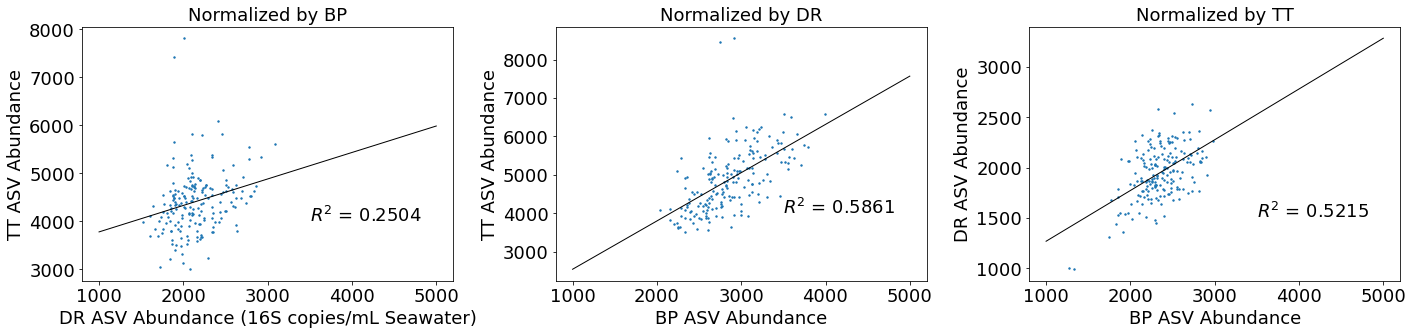

In [34]:
fontsize=18
size = 2
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(1000,5000)

ax[0].scatter(A_DR_IS_BP,A_TT_IS_BP,s=size)
ax[0].plot(x,DR_TT_slope*x+DR_TT_intercept,linewidth=1,c='k')
ax[0].text(3500,4000,'$R^2$ = %s'%(round(DR_TT_r_value,4)))
ax[0].set_title('Normalized by BP')
ax[0].set_xlabel('DR ASV Abundance (16S copies/mL Seawater)')
ax[0].set_ylabel('TT ASV Abundance')

ax[1].scatter(A_BP_IS_DR,A_TT_IS_DR,s=size)
ax[1].plot(x,BP_TT_slope*x+BP_TT_intercept,linewidth=1,c='k')
ax[1].text(3500,4000,'$R^2$ = %s'%(round(BP_TT_r_value,4)))
ax[1].set_title('Normalized by DR')
ax[1].set_xlabel('BP ASV Abundance')
ax[1].set_ylabel('TT ASV Abundance')

ax[2].scatter(A_BP_IS_TT,A_DR_IS_TT,s=size)
ax[2].plot(x,BP_DR_slope*x+BP_DR_intercept,linewidth=1,c='k')
ax[2].text(3500,1500,'$R^2$ = %s'%(round(BP_DR_r_value,4)))
ax[2].set_title('Normalized by TT')
ax[2].set_xlabel('BP ASV Abundance')
ax[2].set_ylabel('DR ASV Abundance')

plt.tight_layout()
plt.show()

Check which samples are the bad estimates

In [38]:
for key,values in IS_abundances.items():
    if np.any([v > 7000 for v in values]):
        print(key)

7C
19C


In [39]:
for key,values in IS_abundances.items():
    if np.any([v < 1000 for v in values]):
        print(key)

7C


NOTE: Both 7C & 19C are part of batch 8i; seems like TT maybe has some pipetting error for that batch 

### Estimate SAR11, Prochlorococcus & Synechococcus

Pro and SAR11 have 1 ASV per cell, Syn has 2.

In [40]:
tax_dir = '/Users/lexijones/Dropbox (MIT)/Grad_School/Research/G4_consolidated/data/HighCoverage_221107/16S/'
tax_file = '221009-0908.LexiGradients-HighCov.16S.taxonomy.tsv'

NOTE: This OTU is being counted toward both Pro and Syn right now.
    
d__Bacteria; p__Cyanobacteria; c__Cyanobacteriia; o__Synechococcales; f__Cyanobiaceae; g__Prochlorococcus_MIT9313; s__Synechococcus_sp.
OTU: cf6481db05a7943d19332115012f0cf8

In [43]:
pro_OTUs,SAR11_OTUs,syn_OTUs = [],[],[]
with open(tax_dir + tax_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    c = 0
    for row in csv_reader:
        if c == 0:
            print(row)
        else:
            OTU,taxonomy = row[0],row[1]            
            if 'Prochlorococcus' in taxonomy:
                pro_OTUs.append(OTU)
            if 'SAR11' in taxonomy:
                SAR11_OTUs.append(OTU)
            if 'Synechococcus' in taxonomy:
                syn_OTUs.append(OTU)
        c += 1
        
print(len(pro_OTUs))
print(len(np.unique(pro_OTUs)))
print(len(SAR11_OTUs))
print(len(np.unique(SAR11_OTUs)))
print(len(syn_OTUs))
print(len(np.unique(syn_OTUs)))

['#OTUID', 'taxonomy', 'confidence']
168
168
1186
1186
31
31


In [44]:
reads = {} # key: [Pro,SAR11,Biomass]

pro_reads,SAR11_reads,syn_reads,biomass_reads = [],[],[],[]
with open(ASV_count_dir + ASV_count_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    c = 0
    for row in csv_reader:
        if c == 0:
            header = row[1:-1]
        else:
            biomass_reads.append([float(r) for r in row[1:-1]])
            
            OTU = row[0]
            if OTU in pro_OTUs:
                pro_reads.append([float(r) for r in row[1:-1]])
            elif OTU in SAR11_OTUs:
                SAR11_reads.append([float(r) for r in row[1:-1]])
            elif OTU in syn_OTUs:
                syn_reads.append([float(r) for r in row[1:-1]])
        c +=1 
        
pro_count = np.sum(pro_reads,axis=0)
SAR11_count = np.sum(SAR11_reads,axis=0)
syn_count = np.sum(syn_reads,axis=0)
biomass_count = np.sum(biomass_reads,axis=0)

for i in np.arange(0,len(header)):
    reads[header[i]] = [pro_count[i],SAR11_count[i],syn_count[i],biomass_count[i]]

### QC: Check how Pro & SAR11 abundances compare with different IS

In [45]:
abundances = {} # key: [A_pro_IS_BP,A_pro_IS_DR,A_pro_IS_TT,
                #          0             1           2                         
                #     A_SAR11_IS_BP,A_SAR11_IS_DR,A_SAR11_IS_TT,
                #          3             4              5           
                #     A_syn_IS_BP,A_syn_IS_DR,A_syn_IS_TT,
                #          6             7              8        
                #     A_biomass_IS_BP,A_biomass_IS_DR,A_biomass_IS_TT]
                #          9             10             11     

for key in sample_batches:
    BP_Cs,DR_Cs,TT_Cs = Cs[sample_batches[key]]
    BP_reads,DR_reads,TT_reads = IS_reads[key]
    pro_reads,SAR11_reads,syn_reads,biomass_reads = reads[key]
        
    abundances[key] = [ASV_abundance(pro_reads,'BP'),ASV_abundance(pro_reads,'DR'),ASV_abundance(pro_reads,'TT'),
                       ASV_abundance(SAR11_reads,'BP'),ASV_abundance(SAR11_reads,'DR'),ASV_abundance(SAR11_reads,'TT'),
                       ASV_abundance(syn_reads,'BP'),ASV_abundance(syn_reads,'DR'),ASV_abundance(syn_reads,'TT'),
                       ASV_abundance(biomass_reads,'BP'),ASV_abundance(biomass_reads,'DR'),ASV_abundance(biomass_reads,'TT')]
        

In [46]:
A_pro_IS_BP,A_pro_IS_DR,A_pro_IS_TT = [],[],[]
A_SAR11_IS_BP,A_SAR11_IS_DR,A_SAR11_IS_TT = [],[],[]
A_syn_IS_BP,A_syn_IS_DR,A_syn_IS_TT = [],[],[]
A_biomass_IS_BP,A_biomass_IS_DR,A_biomass_IS_TT = [],[],[]

for key,values in abundances.items():
    A_pro_IS_BP.append(values[0])
    A_pro_IS_DR.append(values[1])
    A_pro_IS_TT.append(values[2])
    A_SAR11_IS_BP.append(values[3])
    A_SAR11_IS_DR.append(values[4])
    A_SAR11_IS_TT.append(values[5])
    A_syn_IS_BP.append(values[6])
    A_syn_IS_DR.append(values[7])
    A_syn_IS_TT.append(values[8])
    A_biomass_IS_BP.append(values[9])
    A_biomass_IS_DR.append(values[10])
    A_biomass_IS_TT.append(values[11])

pro_IS_BP_DR_slope,pro_IS_BP_DR_intercept,pro_IS_BP_DR_r_value,pro_IS_BP_DR_p_value,pro_IS_BP_DR_std_err = stats.linregress(A_pro_IS_BP,A_pro_IS_DR)
pro_IS_BP_TT_slope,pro_IS_BP_TT_intercept,pro_IS_BP_TT_r_value,pro_IS_BP_TT_p_value,pro_IS_BP_TT_std_err = stats.linregress(A_pro_IS_BP,A_pro_IS_TT)
pro_IS_DR_TT_slope,pro_IS_DR_TT_intercept,pro_IS_DR_TT_r_value,pro_IS_DR_TT_p_value,pro_IS_DR_TT_std_err = stats.linregress(A_pro_IS_DR,A_pro_IS_TT)

SAR11_IS_BP_DR_slope,SAR11_IS_BP_DR_intercept,SAR11_IS_BP_DR_r_value,SAR11_IS_BP_DR_p_value,SAR11_IS_BP_DR_std_err = stats.linregress(A_SAR11_IS_BP,A_SAR11_IS_DR)
SAR11_IS_BP_TT_slope,SAR11_IS_BP_TT_intercept,SAR11_IS_BP_TT_r_value,SAR11_IS_BP_TT_p_value,SAR11_IS_BP_TT_std_err = stats.linregress(A_SAR11_IS_BP,A_SAR11_IS_TT)
SAR11_IS_DR_TT_slope,SAR11_IS_DR_TT_intercept,SAR11_IS_DR_TT_r_value,SAR11_IS_DR_TT_p_value,SAR11_IS_DR_TT_std_err = stats.linregress(A_SAR11_IS_DR,A_SAR11_IS_TT)

syn_IS_BP_DR_slope,syn_IS_BP_DR_intercept,syn_IS_BP_DR_r_value,syn_IS_BP_DR_p_value,syn_IS_BP_DR_std_err = stats.linregress(A_syn_IS_BP,A_syn_IS_DR)
syn_IS_BP_TT_slope,syn_IS_BP_TT_intercept,syn_IS_BP_TT_r_value,syn_IS_BP_TT_p_value,syn_IS_BP_TT_std_err = stats.linregress(A_syn_IS_BP,A_syn_IS_TT)
syn_IS_DR_TT_slope,syn_IS_DR_TT_intercept,syn_IS_DR_TT_r_value,syn_IS_DR_TT_p_value,syn_IS_DR_TT_std_err = stats.linregress(A_syn_IS_DR,A_syn_IS_TT)

biomass_IS_BP_DR_slope,biomass_IS_BP_DR_intercept,biomass_IS_BP_DR_r_value,biomass_IS_BP_DR_p_value,biomass_IS_BP_DR_std_err = stats.linregress(A_biomass_IS_BP,A_biomass_IS_DR)
biomass_IS_BP_TT_slope,biomass_IS_BP_TT_intercept,biomass_IS_BP_TT_r_value,biomass_IS_BP_TT_p_value,biomass_IS_BP_TT_std_err = stats.linregress(A_biomass_IS_BP,A_biomass_IS_TT)
biomass_IS_DR_TT_slope,biomass_IS_DR_TT_intercept,biomass_IS_DR_TT_r_value,biomass_IS_DR_TT_p_value,biomass_IS_DR_TT_std_err = stats.linregress(A_biomass_IS_DR,A_biomass_IS_TT)

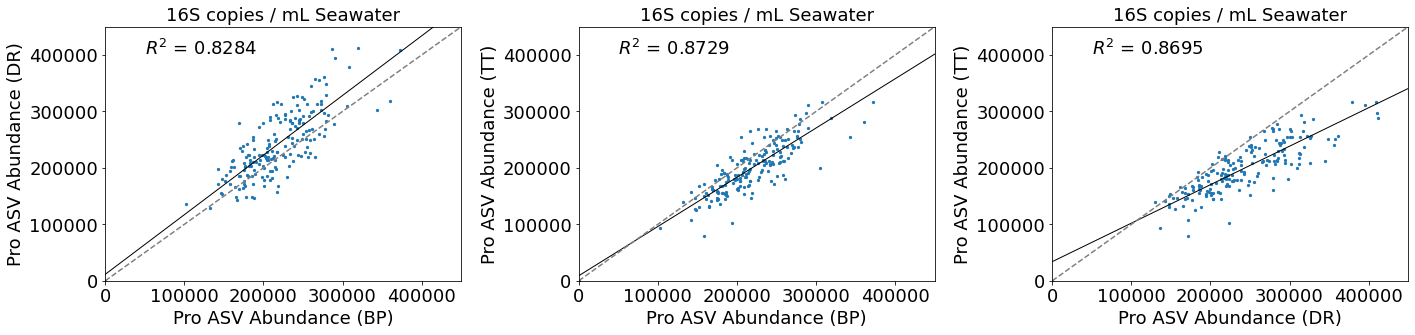

In [47]:
fontsize=18
size = 5
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(0,450000)

ax[0].scatter(A_pro_IS_BP,A_pro_IS_DR,s=size)
ax[0].plot(x,pro_IS_BP_DR_slope*x+pro_IS_BP_DR_intercept,linewidth=1,c='k')
ax[0].text(50000,400000,'$R^2$ = %s'%(round(pro_IS_BP_DR_r_value,4)))
ax[0].set_xlabel('Pro ASV Abundance (BP)')
ax[0].set_ylabel('Pro ASV Abundance (DR)')

ax[1].scatter(A_pro_IS_BP,A_pro_IS_TT,s=size)
ax[1].plot(x,pro_IS_BP_TT_slope*x+pro_IS_BP_TT_intercept,linewidth=1,c='k')
ax[1].text(50000,400000,'$R^2$ = %s'%(round(pro_IS_BP_TT_r_value,4)))
ax[1].set_xlabel('Pro ASV Abundance (BP)')
ax[1].set_ylabel('Pro ASV Abundance (TT)')

ax[2].scatter(A_pro_IS_DR,A_pro_IS_TT,s=size)
ax[2].plot(x,pro_IS_DR_TT_slope*x+pro_IS_DR_TT_intercept,linewidth=1,c='k')
ax[2].text(50000,400000,'$R^2$ = %s'%(round(pro_IS_DR_TT_r_value,4)))
ax[2].set_xlabel('Pro ASV Abundance (DR)')
ax[2].set_ylabel('Pro ASV Abundance (TT)')

for i in np.arange(0,3):
    ax[i].set_title('16S copies / mL Seawater')
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlim([0,450000])
    ax[i].set_ylim([0,450000])
    ax[i].set_xticks(np.arange(0,500000,100000))
    ax[i].set_yticks(np.arange(0,500000,100000))
    
plt.tight_layout()
plt.show()

In [48]:
for key,values in abundances.items():
    if (values[0] > 300000) and (values[2] > 270000):
        print(key)

53A
63B
62C
63C


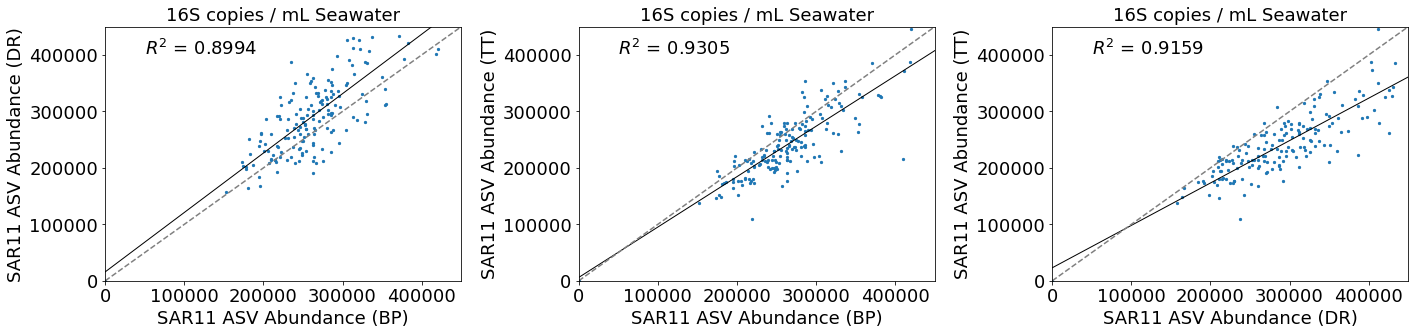

In [50]:
fontsize=18
size = 5
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(0,450000)

ax[0].scatter(A_SAR11_IS_BP,A_SAR11_IS_DR,s=size)
ax[0].plot(x,SAR11_IS_BP_DR_slope*x+SAR11_IS_BP_DR_intercept,linewidth=1,c='k')
ax[0].text(50000,400000,'$R^2$ = %s'%(round(SAR11_IS_BP_DR_r_value,4)))
ax[0].set_xlabel('SAR11 ASV Abundance (BP)')
ax[0].set_ylabel('SAR11 ASV Abundance (DR)')

ax[1].scatter(A_SAR11_IS_BP,A_SAR11_IS_TT,s=size)
ax[1].plot(x,SAR11_IS_BP_TT_slope*x+SAR11_IS_BP_TT_intercept,linewidth=1,c='k')
ax[1].text(50000,400000,'$R^2$ = %s'%(round(SAR11_IS_BP_TT_r_value,4)))
ax[1].set_xlabel('SAR11 ASV Abundance (BP)')
ax[1].set_ylabel('SAR11 ASV Abundance (TT)')

ax[2].scatter(A_SAR11_IS_DR,A_SAR11_IS_TT,s=size)
ax[2].plot(x,SAR11_IS_DR_TT_slope*x+SAR11_IS_DR_TT_intercept,linewidth=1,c='k')
ax[2].text(50000,400000,'$R^2$ = %s'%(round(SAR11_IS_DR_TT_r_value,4)))
ax[2].set_xlabel('SAR11 ASV Abundance (DR)')
ax[2].set_ylabel('SAR11 ASV Abundance (TT)')

for i in np.arange(0,3):
    ax[i].set_title('16S copies / mL Seawater')
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlim([0,450000])
    ax[i].set_ylim([0,450000])
    ax[i].set_xticks(np.arange(0,500000,100000))
    ax[i].set_yticks(np.arange(0,500000,100000))
    
plt.tight_layout()
plt.show()

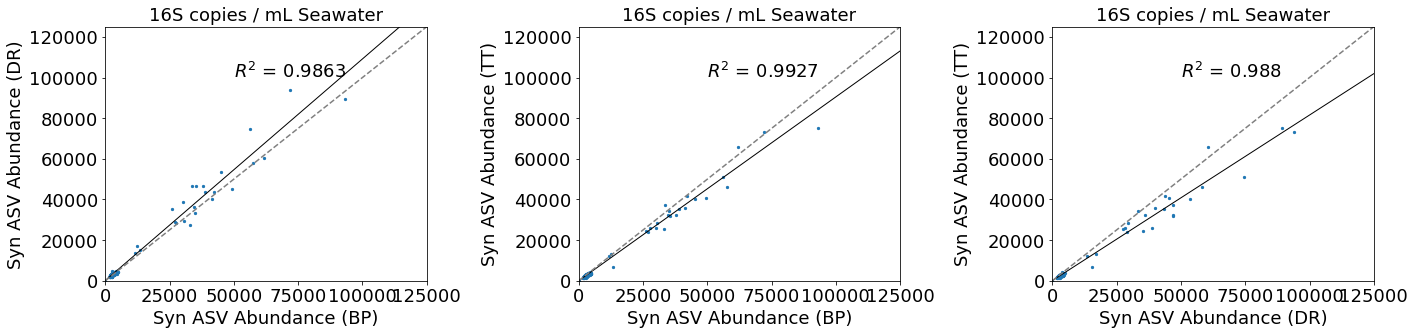

In [51]:
fontsize=18
size = 5
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(0,125000)

ax[0].scatter(A_syn_IS_BP,A_syn_IS_DR,s=size)
ax[0].plot(x,syn_IS_BP_DR_slope*x+syn_IS_BP_DR_intercept,linewidth=1,c='k')
ax[0].text(50000,100000,'$R^2$ = %s'%(round(syn_IS_BP_DR_r_value,4)))
ax[0].set_xlabel('Syn ASV Abundance (BP)')
ax[0].set_ylabel('Syn ASV Abundance (DR)')

ax[1].scatter(A_syn_IS_BP,A_syn_IS_TT,s=size)
ax[1].plot(x,syn_IS_BP_TT_slope*x+syn_IS_BP_TT_intercept,linewidth=1,c='k')
ax[1].text(50000,100000,'$R^2$ = %s'%(round(syn_IS_BP_TT_r_value,4)))
ax[1].set_xlabel('Syn ASV Abundance (BP)')
ax[1].set_ylabel('Syn ASV Abundance (TT)')

ax[2].scatter(A_syn_IS_DR,A_syn_IS_TT,s=size)
ax[2].plot(x,syn_IS_DR_TT_slope*x+syn_IS_DR_TT_intercept,linewidth=1,c='k')
ax[2].text(50000,100000,'$R^2$ = %s'%(round(syn_IS_DR_TT_r_value,4)))
ax[2].set_xlabel('Syn ASV Abundance (DR)')
ax[2].set_ylabel('Syn ASV Abundance (TT)')

for i in np.arange(0,3):
    ax[i].set_title('16S copies / mL Seawater')
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlim([0,125000])
    ax[i].set_ylim([0,125000])
 #   ax[i].set_xticks(np.arange(0,500000,100000))
 #   ax[i].set_yticks(np.arange(0,500000,100000))
    
plt.tight_layout()
plt.show()

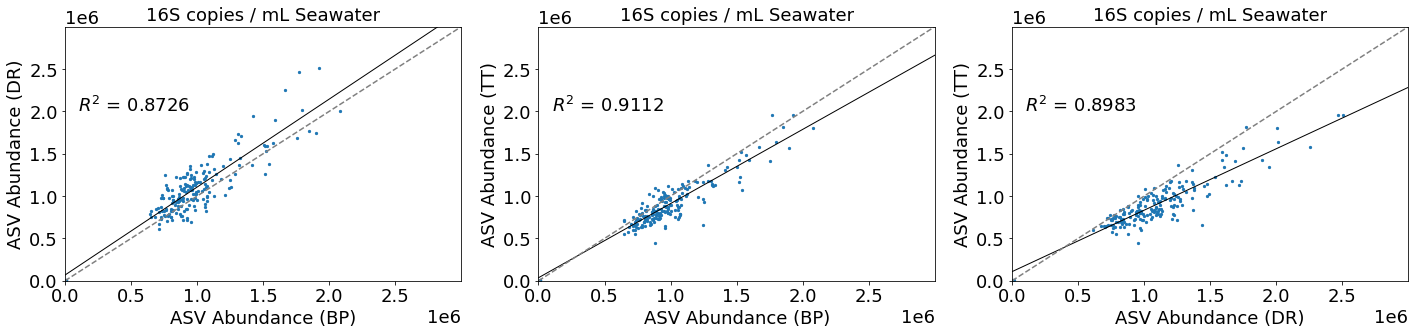

In [52]:
fontsize=18
size = 5
fig,ax = plt.subplots(1,3,figsize=(20,5))

xmin,xmax = 0,3000000
x = np.arange(xmin,xmax)

ax[0].scatter(A_biomass_IS_BP,A_biomass_IS_DR,s=size)
ax[0].plot(x,biomass_IS_BP_DR_slope*x+biomass_IS_BP_DR_intercept,linewidth=1,c='k')
ax[0].text(100000,2000000,'$R^2$ = %s'%(round(biomass_IS_BP_DR_r_value,4)))
ax[0].set_xlabel('ASV Abundance (BP)')
ax[0].set_ylabel('ASV Abundance (DR)')

ax[1].scatter(A_biomass_IS_BP,A_biomass_IS_TT,s=size)
ax[1].plot(x,biomass_IS_BP_TT_slope*x+biomass_IS_BP_TT_intercept,linewidth=1,c='k')
ax[1].text(100000,2000000,'$R^2$ = %s'%(round(biomass_IS_BP_TT_r_value,4)))
ax[1].set_xlabel('ASV Abundance (BP)')
ax[1].set_ylabel('ASV Abundance (TT)')

ax[2].scatter(A_biomass_IS_DR,A_biomass_IS_TT,s=size)
ax[2].plot(x,biomass_IS_DR_TT_slope*x+biomass_IS_DR_TT_intercept,linewidth=1,c='k')
ax[2].text(100000,2000000,'$R^2$ = %s'%(round(biomass_IS_DR_TT_r_value,4)))
ax[2].set_xlabel('ASV Abundance (DR)')
ax[2].set_ylabel('ASV Abundance (TT)')

for i in np.arange(0,3):
    ax[i].set_title('16S copies / mL Seawater')
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlim([xmin,xmax])
    ax[i].set_ylim([xmin,xmax])
    ax[i].set_xticks(np.arange(xmin,xmax,500000))
    ax[i].set_yticks(np.arange(xmin,xmax,500000))
    
plt.tight_layout()
plt.show()

In [53]:
for key,values in abundances.items():
    if (values[7] > 2*(10**6)):
        print(key)

### Sample Triplicate Comparison

Samples were taken in triplicate on the cruise. We would expect any one ASV to be similar quantities amongst the triplicates.

NOTE: 20Ai and 20Aii are already excluded here because they were part of batch 2

In [57]:
matched_stations = []
for key,values in abundances.items():
    if (key == 'LB-and-IS') or (key == '72') or (key == 'R45v2'): # exclude blanks
        pass
    elif (key.startswith('B')): # exclude unknown samples
        pass
    else:
        station = key.split('A')[0].split('B')[0].split('C')[0]
        for other_key in abundances:
            if other_key != key:
                other_station = other_key.split('A')[0].split('B')[0].split('C')[0]
                if other_station == station:
                    if [other_key,key] not in matched_stations:
                        matched_stations.append([key,other_key])
                        
len(matched_stations)

157

In [58]:
def values_from_pairs(ind):
    x,y = [],[]
    for pair in matched_stations:
        x.append(abundances[pair[1]][ind])
        y.append(abundances[pair[0]][ind])
        
    slope,intercept,r_value,p_value,std_err = stats.linregress(x,y)
    return x,y,slope,intercept,r_value

In [59]:
pro_BP_x,pro_BP_y,pro_BP_slope,pro_BP_intercept,pro_BP_rvalue = values_from_pairs(0)
pro_DR_x,pro_DR_y,pro_DR_slope,pro_DR_intercept,pro_DR_rvalue = values_from_pairs(1)
pro_TT_x,pro_TT_y,pro_TT_slope,pro_TT_intercept,pro_TT_rvalue = values_from_pairs(2)

SAR11_BP_x,SAR11_BP_y,SAR11_BP_slope,SAR11_BP_intercept,SAR11_BP_rvalue = values_from_pairs(3)
SAR11_DR_x,SAR11_DR_y,SAR11_DR_slope,SAR11_DR_intercept,SAR11_DR_rvalue = values_from_pairs(4)
SAR11_TT_x,SAR11_TT_y,SAR11_TT_slope,SAR11_TT_intercept,SAR11_TT_rvalue = values_from_pairs(5)

syn_BP_x,syn_BP_y,syn_BP_slope,syn_BP_intercept,syn_BP_rvalue = values_from_pairs(6)
syn_DR_x,syn_DR_y,syn_DR_slope,syn_DR_intercept,syn_DR_rvalue = values_from_pairs(7)
syn_TT_x,syn_TT_y,syn_TT_slope,syn_TT_intercept,syn_TT_rvalue = values_from_pairs(8)

biomass_BP_x,biomass_BP_y,biomass_BP_slope,biomass_BP_intercept,biomass_BP_rvalue = values_from_pairs(9)
biomass_DR_x,biomass_DR_y,biomass_DR_slope,biomass_DR_intercept,biomass_DR_rvalue = values_from_pairs(10)
biomass_TT_x,biomass_TT_y,biomass_TT_slope,biomass_TT_intercept,biomass_TT_rvalue = values_from_pairs(11)

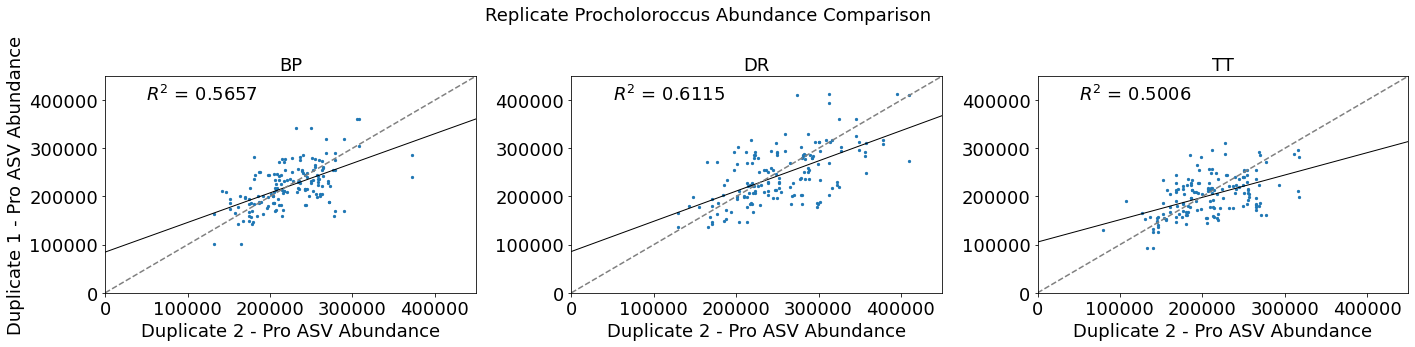

In [61]:
fontsize=18
size = 5
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(0,450000)

ax[0].scatter(pro_BP_x,pro_BP_y,s=size)
ax[0].plot(x,pro_BP_slope*x+pro_BP_intercept,linewidth=1,c='k')
ax[0].text(50000,400000,'$R^2$ = %s'%(round(pro_BP_rvalue,4)))
ax[0].set_title('BP')

ax[1].scatter(pro_DR_x,pro_DR_y,s=size)
ax[1].plot(x,pro_DR_slope*x+pro_DR_intercept,linewidth=1,c='k')
ax[1].text(50000,400000,'$R^2$ = %s'%(round(pro_DR_rvalue,4)))
ax[1].set_title('DR')

ax[2].scatter(pro_TT_x,pro_TT_y,s=size)
ax[2].plot(x,pro_TT_slope*x+pro_TT_intercept,linewidth=1,c='k')
ax[2].text(50000,400000,'$R^2$ = %s'%(round(pro_TT_rvalue,4)))
ax[2].set_title('TT')

ax[0].set_ylabel('Duplicate 1 - Pro ASV Abundance')
for i in np.arange(0,3):
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlim([0,450000])
    ax[i].set_ylim([0,450000])
    ax[i].set_xticks(np.arange(0,500000,100000))
    ax[i].set_yticks(np.arange(0,500000,100000))
    ax[i].set_xlabel('Duplicate 2 - Pro ASV Abundance')

plt.suptitle('Replicate Procholoroccus Abundance Comparison')
plt.tight_layout()
plt.show()

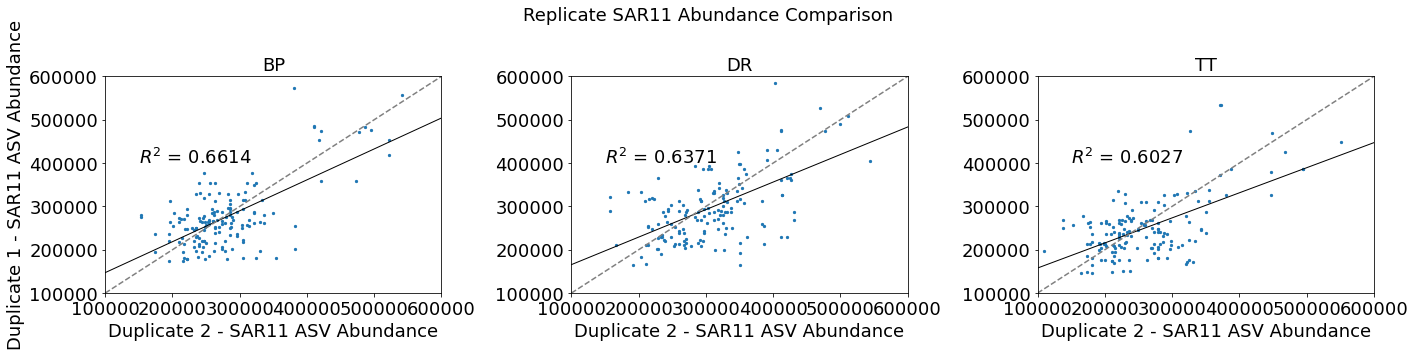

In [62]:
fontsize=18
size = 5
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(100000,600000)

ax[0].scatter(SAR11_BP_x,SAR11_BP_y,s=size)
ax[0].plot(x,SAR11_BP_slope*x+SAR11_BP_intercept,linewidth=1,c='k')
ax[0].text(150000,400000,'$R^2$ = %s'%(round(SAR11_BP_rvalue,4)))
ax[0].set_title('BP')

ax[1].scatter(SAR11_DR_x,SAR11_DR_y,s=size)
ax[1].plot(x,SAR11_DR_slope*x+SAR11_DR_intercept,linewidth=1,c='k')
ax[1].text(150000,400000,'$R^2$ = %s'%(round(SAR11_DR_rvalue,4)))
ax[1].set_title('DR')

ax[2].scatter(SAR11_TT_x,SAR11_TT_y,s=size)
ax[2].plot(x,SAR11_TT_slope*x+SAR11_TT_intercept,linewidth=1,c='k')
ax[2].text(150000,400000,'$R^2$ = %s'%(round(SAR11_TT_rvalue,4)))
ax[2].set_title('TT')

ax[0].set_ylabel('Duplicate 1 - SAR11 ASV Abundance')
for i in np.arange(0,3):
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlim([100000,600000])
    ax[i].set_ylim([100000,600000])
    ax[i].set_xticks(np.arange(100000,650000,100000))
    ax[i].set_yticks(np.arange(100000,650000,100000))
    ax[i].set_xlabel('Duplicate 2 - SAR11 ASV Abundance')

plt.suptitle('Replicate SAR11 Abundance Comparison')

plt.tight_layout()
plt.show()

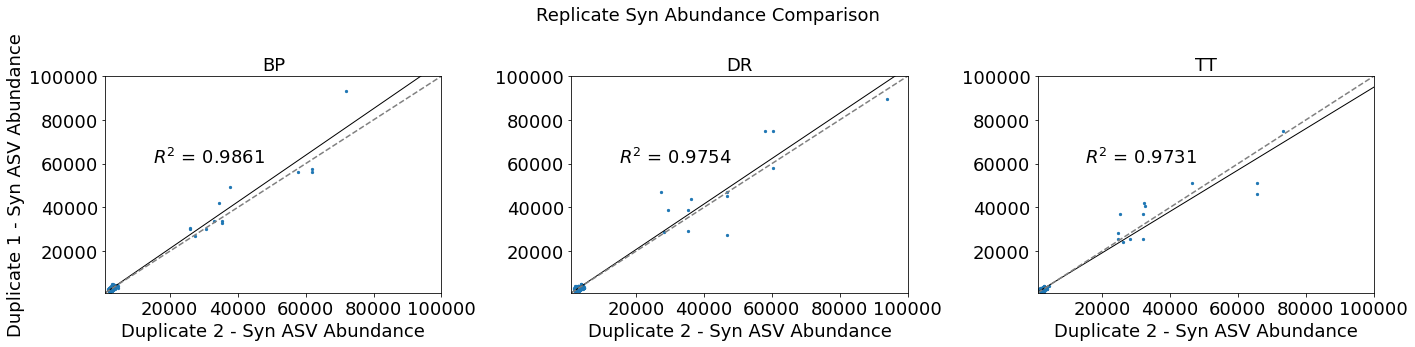

In [63]:
fontsize=18
size = 5
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(1000,100000)

ax[0].scatter(syn_BP_x,syn_BP_y,s=size)
ax[0].plot(x,syn_BP_slope*x+syn_BP_intercept,linewidth=1,c='k')
ax[0].text(15000,60000,'$R^2$ = %s'%(round(syn_BP_rvalue,4)))
ax[0].set_title('BP')

ax[1].scatter(syn_DR_x,syn_DR_y,s=size)
ax[1].plot(x,syn_DR_slope*x+syn_DR_intercept,linewidth=1,c='k')
ax[1].text(15000,60000,'$R^2$ = %s'%(round(syn_DR_rvalue,4)))
ax[1].set_title('DR')

ax[2].scatter(syn_TT_x,syn_TT_y,s=size)
ax[2].plot(x,syn_TT_slope*x+syn_TT_intercept,linewidth=1,c='k')
ax[2].text(15000,60000,'$R^2$ = %s'%(round(syn_TT_rvalue,4)))
ax[2].set_title('TT')

ax[0].set_ylabel('Duplicate 1 - Syn ASV Abundance')
for i in np.arange(0,3):
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlim([1000,100000])
    ax[i].set_ylim([1000,100000])
    #ax[i].set_xticks(np.arange(100000,650000,100000))
    #ax[i].set_yticks(np.arange(100000,650000,100000))
    ax[i].set_xlabel('Duplicate 2 - Syn ASV Abundance')

plt.suptitle('Replicate Syn Abundance Comparison')
plt.tight_layout()

plt.show()

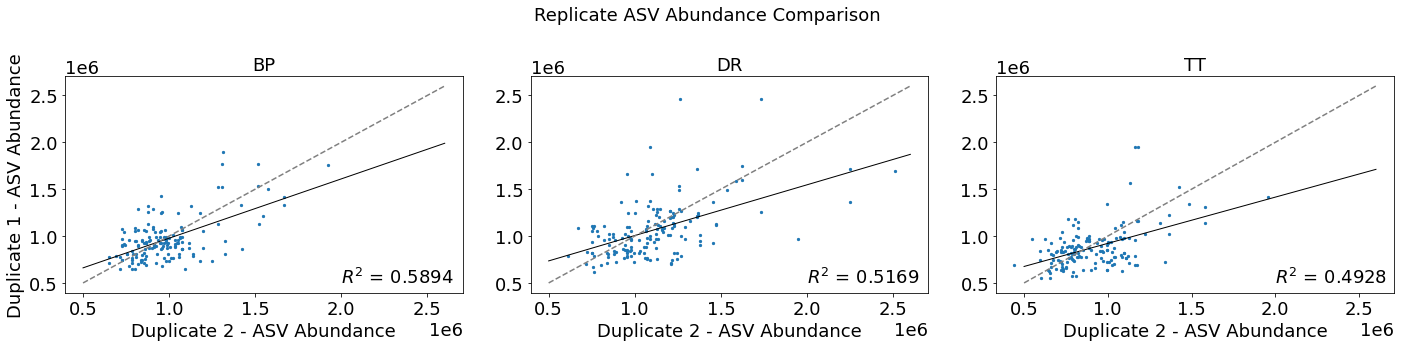

In [64]:
fontsize=18
size = 5
fig,ax = plt.subplots(1,3,figsize=(20,5))

xmin,xmax = 500000,2600000
x = np.arange(xmin,xmax)

ax[0].scatter(biomass_BP_x,biomass_BP_y,s=size)
ax[0].plot(x,biomass_BP_slope*x+biomass_BP_intercept,linewidth=1,c='k')
ax[0].text(2000000,500000,'$R^2$ = %s'%(round(biomass_BP_rvalue,4)))
ax[0].set_title('BP')

ax[1].scatter(biomass_DR_x,biomass_DR_y,s=size)
ax[1].plot(x,biomass_DR_slope*x+biomass_DR_intercept,linewidth=1,c='k')
ax[1].text(2000000,500000,'$R^2$ = %s'%(round(biomass_DR_rvalue,4)))
ax[1].set_title('DR')

ax[2].scatter(biomass_TT_x,biomass_TT_y,s=size)
ax[2].plot(x,biomass_TT_slope*x+biomass_TT_intercept,linewidth=1,c='k')
ax[2].text(2000000,500000,'$R^2$ = %s'%(round(biomass_TT_rvalue,4)))
ax[2].set_title('TT')

ax[0].set_ylabel('Duplicate 1 - ASV Abundance')
for i in np.arange(0,3):
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlabel('Duplicate 2 - ASV Abundance')

plt.suptitle('Replicate ASV Abundance Comparison')
plt.tight_layout()

plt.show()

### Compare Pro and Syn with Flow Cytometry (BD Influx Cell Sorter)

Flow cyt samples are in triplicate

In [65]:
metadata_dir = '/Users/lexijones/Dropbox (MIT)/Grad_School/Research/G4_consolidated/data/'
metadata_file = 'Jones_G4_metadata.tsv'

In [66]:
metadata = {}
with open(metadata_dir + metadata_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    c = 0
    for row in csv_reader:
        if (c != 0) and (len(row) > 3):
            if row[0] in sample_batches:
                metadata[row[0]] = [row[1],row[2],float(row[3]),float(row[4])] #latitude, longitude
        c += 1

In [67]:
def distance_from_lat_lon(lat1,lon1,lat2,lon2):
    """
    Returns the distance in kilometers between two coordinate points. Accepts negative (-180 to 180) or positive coordinate systems
 (0 to 360). 

    lat1,lon1: coordinates for point 1
    lat2,lon2: coordinates for point 2
    """
    R = 6371 # Radius of the earth in km
    delta_lat,delta_lon = math.radians(lat2-lat1),math.radians(lon2-lon1)
    lat1_radians,lat2_radians = math.radians(lat1),math.radians(lat2)
    a = math.sin(delta_lat/2)*math.sin(delta_lat/2)+math.cos(lat1_radians)*math.cos(lat2_radians)*((math.sin(delta_lon/2))**2)
    dist = R*2*math.atan2(math.sqrt(a),math.sqrt(1-a)) # Distance in km
    return dist

In [70]:
flow_cyt_dir = '/Users/lexijones/Dropbox (MIT)/Grad_School/Research/G4_consolidated/data/underway_flow_cyt/'
#flow_cyt_file = 'Discrete_Flow_Cytometry_of_Underway_Samples_from_Gradients_4_2021_Using_a_BD_Influx_Cell_Sorter.csv'
flow_cyt_file = 'Influx_Underway_Gradients_2021.csv'

In [71]:
flow_cyt_data = []
with open(flow_cyt_dir + flow_cyt_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    c = 0
    for row in csv_reader:
        if (c == 0):
            print(row)
            print(row[28])
        elif (row == []):
            pass
        elif (c < 70) and (c > 3): # narrow down to flow cyt samples within range of mine
             #lat,lon,pro abundance,syn_abundance
            flow_cyt_data.append([float(row[1]),float(row[2])+360,float(row[28]),float(row[29])])
        c += 1
flow_cyt_data = np.array(flow_cyt_data)

['time', 'lat', 'lon', 'depth', 'file', 'count_beads', 'count_picoeuk', 'count_prochloro', 'count_synecho', 'count_unknown', 'scatter_beads', 'scatter_picoeuk', 'scatter_prochloro', 'scatter_synecho', 'scatter_unknown', 'red_beads', 'red_picoeuk', 'red_prochloro', 'red_synecho', 'red_unknown', 'orange_beads', 'orange_picoeuk', 'orange_prochloro', 'orange_synecho', 'orange_unknown', 'volume', 'abundance_beads', 'abundance_picoeuk', 'abundance_prochloro', 'abundance_synecho', 'abundance_unknown', 'cell_diameter_beads', 'cell_diameter_picoeuk', 'cell_diameter_prochloro', 'cell_diameter_synecho', 'cell_diameter_unknown', 'carbon_content_beads', 'carbon_content_picoeuk', 'carbon_content_prochloro', 'carbon_content_synecho', 'carbon_content_unknown', 'biomass_beads', 'biomass_picoeuk', 'biomass_prochloro', 'biomass_synecho', 'biomass_unknown', 'flag', 'stain', 'replicate', 'comments']
abundance_prochloro


In [72]:
avg_influx_data = []
for l in np.unique(flow_cyt_data[:,0]):
    pt_inds = flow_cyt_data[np.where(flow_cyt_data[:,0] == l)]
    avg_influx_data.append([pt_inds[0][0],pt_inds[0][1],np.mean(pt_inds[:,2]),np.mean(pt_inds[:,3])])

In [73]:
avg_influx_data

[[16.0449, 219.9977, 218.45709444448002, 1.5099088576151],
 [17.2504, 219.9626, 241.68558277683132, 1.4113008120041133],
 [17.6748, 219.8385, 226.2960442255197, 1.25371260281906],
 [19.1842, 221.0898, 184.28358789958065, 1.0331891341514232],
 [19.5093, 221.4182, 216.42663467958516, 1.275498885080135],
 [19.6376, 221.3842, 219.7253164044603, 1.2451926993165483],
 [19.6514, 221.4323, 192.18774273463032, 1.15582470176044],
 [20.7605, 223.1475, 218.93828629452366, 1.2276767462674467],
 [21.4008, 224.1571, 227.36231486680632, 1.1156866456256915],
 [21.7402, 224.6867, 246.55154082523532, 1.48022077463611],
 [23.0736, 226.8152, 202.01687861855268, 1.4827067437646135],
 [23.7973, 227.9763, 204.64457936997334, 1.3841649399889],
 [24.4889, 229.0952, 227.89246754812234, 1.13816204001963],
 [25.9839, 231.5359, 190.28803942682802, 1.58449126783514],
 [26.7215, 232.75220000000002, 208.73360647860633, 3.0991007920439633],
 [27.0673, 233.3261, 206.02439270779567, 2.0049780293925634],
 [28.33333333, 23

### Pro Matchups

In [74]:
pro_flow_cyt_matchups = {}
for key, value in metadata.items():
    date,time,lat1,lon1 = value # lat/lon of my samples
    for i in avg_influx_data:
        lat2,lon2,pro,_ = i # lat/lon of flow cyt samples
        if distance_from_lat_lon(lat1,lon1,lat2,lon2) < 20:
            if key not in pro_flow_cyt_matchups:
                pro_flow_cyt_matchups[key] = [lat1,lon1,pro*1000]
            else: 
                pro_flow_cyt_matchups[key].append(pro*1000) # convert from microliter to mililiter

In [75]:
pro_flow_cyt_matchups

{'10B': [30.1215, 238.4522, 138265.78697995265],
 '10C': [30.1215, 238.4522, 138265.78697995265],
 '18B': [28.503, 235.714, 145970.64867910332, 176074.82184410936],
 '18C': [28.503, 235.714, 145970.64867910332, 176074.82184410936],
 '19B': [28.2847, 235.3517, 160583.70273481635],
 '19C': [28.2847, 235.3517, 160583.70273481635],
 '24A': [27.0992, 233.374, 206024.39270779566],
 '24B': [27.0992, 233.374, 206024.39270779566],
 '24C': [27.0992, 233.374, 206024.39270779566],
 '26B': [26.652, 232.6401, 208733.60647860632],
 '26C': [26.652, 232.6401, 208733.60647860632],
 '29A': [25.9711, 231.5141, 190288.039426828],
 '29B': [25.9711, 231.5141, 190288.039426828],
 '29C': [25.9711, 231.5141, 190288.039426828],
 '41A': [23.1732, 226.9761, 202016.87861855267],
 '41B': [23.1732, 226.9761, 202016.87861855267],
 '41Cv2': [23.1732, 226.9761, 202016.87861855267],
 '48A': [21.7525, 224.7086, 246551.5408252353],
 '48B': [21.7525, 224.7086, 246551.5408252353],
 '48Cv2': [21.7525, 224.7086, 246551.5408252

In [77]:
A_pro_IS_BP_for_flow_cyt = []
A_pro_IS_DR_for_flow_cyt = []
A_pro_IS_TT_for_flow_cyt = []
all_flow_cyt_pro = []
all_flow_cyt_lats = []

for key in pro_flow_cyt_matchups:
    flow_cyt_pro = pro_flow_cyt_matchups[key][2:]
        
    for j in np.arange(0,len(flow_cyt_pro)):
        A_pro_IS_BP_for_flow_cyt.append(abundances[key][0])
        A_pro_IS_DR_for_flow_cyt.append(abundances[key][1])
        A_pro_IS_TT_for_flow_cyt.append(abundances[key][2])
        all_flow_cyt_pro.append(flow_cyt_pro[j]) 
        all_flow_cyt_lats.append(pro_flow_cyt_matchups[key][0])

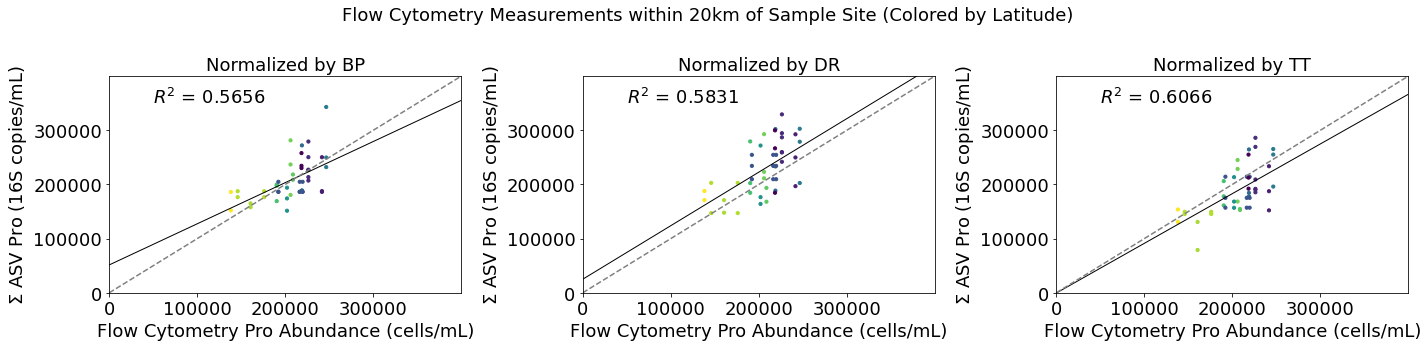

In [78]:
fontsize=18
size = 10
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(0,400000)

BP_slope,BP_intercept,BP_r_value,BP_p_value,BP_std_err = stats.linregress(all_flow_cyt_pro,A_pro_IS_BP_for_flow_cyt)
DR_slope,DR_intercept,DR_r_value,DR_p_value,DR_std_err = stats.linregress(all_flow_cyt_pro,A_pro_IS_DR_for_flow_cyt)
TT_slope,TT_intercept,TT_r_value,TT_p_value,TT_std_err = stats.linregress(all_flow_cyt_pro,A_pro_IS_TT_for_flow_cyt)

ax[0].scatter(all_flow_cyt_pro,A_pro_IS_BP_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax[0].plot(x,BP_slope*x+BP_intercept,linewidth=1,c='k')
ax[0].text(50000,350000,'$R^2$ = %s'%(round(BP_r_value,4)))
ax[0].set_ylabel('$\Sigma$ ASV Pro (16S copies/mL)')
ax[0].set_xlabel('Flow Cytometry Pro Abundance (cells/mL)')
ax[0].set_title('Normalized by BP')

ax[1].scatter(all_flow_cyt_pro,A_pro_IS_DR_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax[1].plot(x,DR_slope*x+DR_intercept,linewidth=1,c='k')
ax[1].text(50000,350000,'$R^2$ = %s'%(round(DR_r_value,4)))
ax[1].set_ylabel('$\Sigma$ ASV Pro (16S copies/mL)')
ax[1].set_xlabel('Flow Cytometry Pro Abundance (cells/mL)')
ax[1].set_title('Normalized by DR')

ax[2].scatter(all_flow_cyt_pro,A_pro_IS_TT_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax[2].plot(x,TT_slope*x+TT_intercept,linewidth=1,c='k')
ax[2].text(50000,350000,'$R^2$ = %s'%(round(TT_r_value,4)))
ax[2].set_ylabel('$\Sigma$ ASV Pro (16S copies/mL)')
ax[2].set_xlabel('Flow Cytometry Pro Abundance (cells/mL)')
ax[2].set_title('Normalized by TT')


for i in np.arange(0,3):
    ax[i].plot(x,x,linestyle='--',c='gray')
    ax[i].set_xlim([0,400000])
    ax[i].set_ylim([0,400000])
    ax[i].set_xticks(np.arange(0,400000,100000))
    ax[i].set_yticks(np.arange(0,400000,100000))
    
plt.suptitle('Flow Cytometry Measurements within 20km of Sample Site (Colored by Latitude)')   
plt.tight_layout()
plt.show()

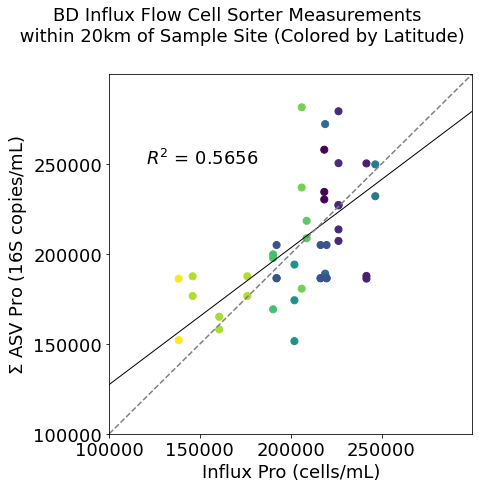

In [80]:
fontsize=18
size = 50
fig,ax = plt.subplots(1,1,figsize=(7,7))

x = np.arange(0,400000)

BP_slope,BP_intercept,BP_r_value,BP_p_value,BP_std_err = stats.linregress(all_flow_cyt_pro,A_pro_IS_BP_for_flow_cyt)

ax.scatter(all_flow_cyt_pro,A_pro_IS_BP_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax.plot(x,BP_slope*x+BP_intercept,linewidth=1,c='k')
ax.text(120000,250000,'$R^2$ = %s'%(round(BP_r_value,4)),fontsize=fontsize)
ax.set_ylabel('$\Sigma$ ASV Pro (16S copies/mL)',fontsize=fontsize)
ax.set_xlabel('Influx Pro (cells/mL)',fontsize=fontsize)
#ax.set_title('Normalized by BP')

ax.plot(x,x,linestyle='--',c='gray')
ax.set_xlim([100000,300000])
ax.set_ylim([100000,300000])
ax.set_xticks(np.arange(100000,300000,50000))
ax.set_yticks(np.arange(100000,300000,50000))
ax.tick_params(axis='both', labelsize=fontsize)

plt.suptitle('BD Influx Flow Cell Sorter Measurements \n within 20km of Sample Site (Colored by Latitude)',fontsize=fontsize)   
plt.tight_layout()

plt.show()

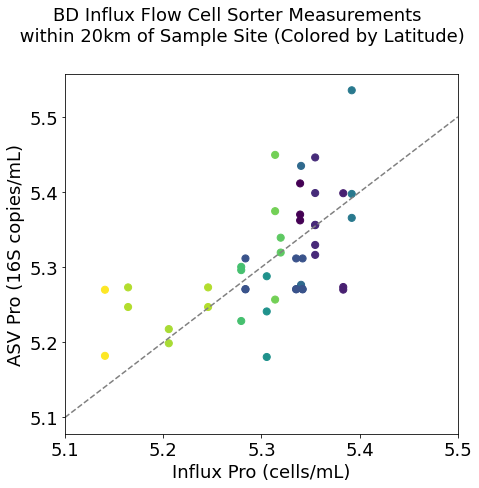

In [81]:
fontsize=18
size = 50
fig,ax = plt.subplots(1,1,figsize=(7,7))

xmin,xmax = 5.1,5.5


x = np.arange(xmin,xmax,0.1)


#BP_slope,BP_intercept,BP_r_value,BP_p_value,BP_std_err = stats.linregress(all_flow_cyt_pro,A_pro_IS_BP_for_flow_cyt)

ax.scatter(np.log10(all_flow_cyt_pro),np.log10(A_pro_IS_BP_for_flow_cyt),s=size,c=all_flow_cyt_lats)
#ax.plot(x,BP_slope*x+BP_intercept,linewidth=1,c='k')
#ax.text(120000,250000,'$R^2$ = %s'%(round(BP_r_value,4)),fontsize=fontsize)
ax.set_ylabel('ASV Pro (16S copies/mL)',fontsize=fontsize)
ax.set_xlabel('Influx Pro (cells/mL)',fontsize=fontsize)
#ax.set_title('Normalized by BP')

ax.plot(x,x,linestyle='--',c='gray')
ax.set_xlim([xmin,xmax])
#ax.set_ylim([100000,300000])
#ax.set_xticks(np.arange(100000,300000,50000))
#ax.set_yticks(np.arange(100000,300000,50000))
ax.tick_params(axis='both', labelsize=fontsize)

plt.suptitle('BD Influx Flow Cell Sorter Measurements \n within 20km of Sample Site (Colored by Latitude)',fontsize=fontsize)   
plt.tight_layout()

plt.show()

### Syn Matchups

In [82]:
syn_flow_cyt_matchups = {}
for key, value in metadata.items():
    date,time,lat1,lon1 = value # lat/lon of my samples
    for i in avg_influx_data:
        lat2,lon2,_,syn = i # lat/lon of flow cyt samples
        if distance_from_lat_lon(lat1,lon1,lat2,lon2) < 20:
            if key not in syn_flow_cyt_matchups:
                syn_flow_cyt_matchups[key] = [lat1,lon1,syn*1000]
            else: 
                syn_flow_cyt_matchups[key].append(syn*1000) # convert from microliter to mililiter

In [83]:
A_syn_IS_BP_for_flow_cyt = []
A_syn_IS_DR_for_flow_cyt = []
A_syn_IS_TT_for_flow_cyt = []
all_flow_cyt_syn = []
all_flow_cyt_lats = []

for key in syn_flow_cyt_matchups:
    flow_cyt_syn = syn_flow_cyt_matchups[key][2:]
        
    for j in np.arange(0,len(flow_cyt_syn)):
        A_syn_IS_BP_for_flow_cyt.append(abundances[key][6]) 
        A_syn_IS_DR_for_flow_cyt.append(abundances[key][7])
        A_syn_IS_TT_for_flow_cyt.append(abundances[key][8])
        all_flow_cyt_syn.append(flow_cyt_syn[j]*2) # multiply by 2 because 2 ASVs per cell
        all_flow_cyt_lats.append(syn_flow_cyt_matchups[key][0])

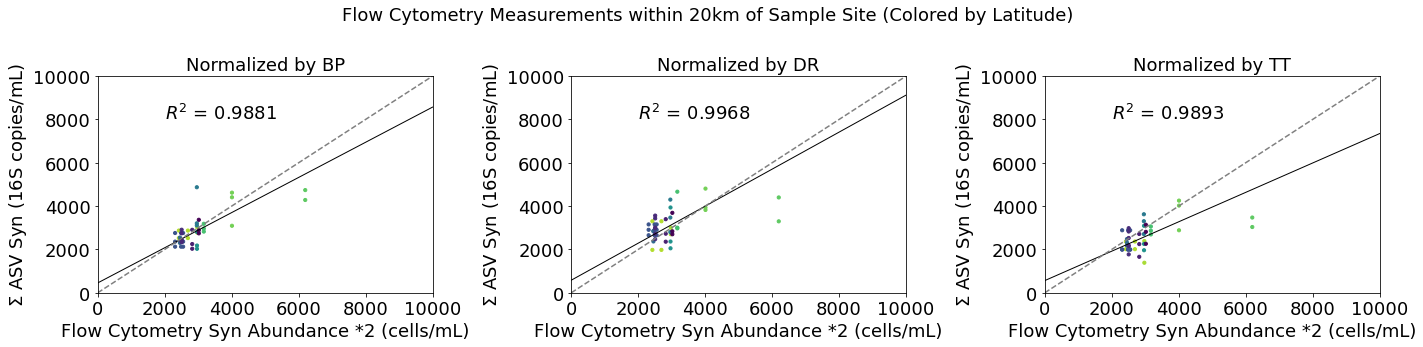

In [85]:
fontsize=18
size = 10
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(0,30000)

BP_slope,BP_intercept,BP_r_value,BP_p_value,BP_std_err = stats.linregress(all_flow_cyt_syn,A_syn_IS_BP_for_flow_cyt)
DR_slope,DR_intercept,DR_r_value,DR_p_value,DR_std_err = stats.linregress(all_flow_cyt_syn,A_syn_IS_DR_for_flow_cyt)
TT_slope,TT_intercept,TT_r_value,TT_p_value,TT_std_err = stats.linregress(all_flow_cyt_syn,A_syn_IS_TT_for_flow_cyt)

ax[0].scatter(all_flow_cyt_syn,A_syn_IS_BP_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax[0].plot(x,BP_slope*x+BP_intercept,linewidth=1,c='k')
ax[0].text(2000,8000,'$R^2$ = %s'%(round(BP_r_value,4)))
ax[0].set_ylabel('$\Sigma$ ASV Syn (16S copies/mL)')
ax[0].set_xlabel('Flow Cytometry Syn Abundance *2 (cells/mL)')
ax[0].set_title('Normalized by BP')

ax[1].scatter(all_flow_cyt_syn,A_syn_IS_DR_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax[1].plot(x,DR_slope*x+DR_intercept,linewidth=1,c='k')
ax[1].text(2000,8000,'$R^2$ = %s'%(round(DR_r_value,4)))
ax[1].set_ylabel('$\Sigma$ ASV Syn (16S copies/mL)')
ax[1].set_xlabel('Flow Cytometry Syn Abundance *2 (cells/mL)')
ax[1].set_title('Normalized by DR')

ax[2].scatter(all_flow_cyt_syn,A_syn_IS_TT_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax[2].plot(x,TT_slope*x+TT_intercept,linewidth=1,c='k')
ax[2].text(2000,8000,'$R^2$ = %s'%(round(TT_r_value,4)))
ax[2].set_ylabel('$\Sigma$ ASV Syn (16S copies/mL)')
ax[2].set_xlabel('Flow Cytometry Syn Abundance *2 (cells/mL)')
ax[2].set_title('Normalized by TT')


for i in np.arange(0,3):
    ax[i].plot(x,x,linestyle='--',c='gray')
    #ax[i].set_xlim([0,30000])
    #ax[i].set_ylim([0,30000])
    ax[i].set_xlim([0,10000])
    ax[i].set_ylim([0,10000])
    

plt.suptitle('Flow Cytometry Measurements within 20km of Sample Site (Colored by Latitude)')   
plt.tight_layout()
plt.show()

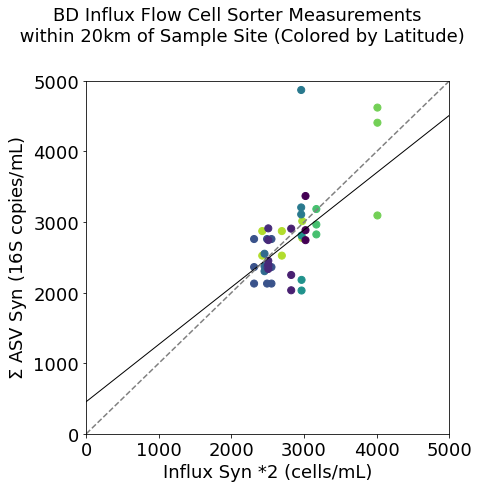

In [86]:
fontsize=18
size = 50
fig,ax = plt.subplots(1,1,figsize=(7,7))

x = np.arange(0,30000)

BP_slope,BP_intercept,BP_r_value,BP_p_value,BP_std_err = stats.linregress(all_flow_cyt_syn,A_syn_IS_BP_for_flow_cyt)

ax.scatter(all_flow_cyt_syn,A_syn_IS_BP_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax.plot(x,BP_slope*x+BP_intercept,linewidth=1,c='k')
#ax.text(10000,25000,'$R^2$ = %s'%(round(BP_r_value,4)),fontsize=fontsize)
ax.set_ylabel('$\Sigma$ ASV Syn (16S copies/mL)',fontsize=fontsize)
ax.set_xlabel('Influx Syn *2 (cells/mL)',fontsize=fontsize)

ax.plot(x,x,linestyle='--',c='gray')
ax.set_xlim([0,5000])
ax.set_ylim([0,5000])
ax.tick_params(axis='both', labelsize=fontsize)

plt.suptitle('BD Influx Flow Cell Sorter Measurements \n within 20km of Sample Site (Colored by Latitude)',fontsize=fontsize)   
plt.tight_layout()
plt.show()

### Pro:Syn Matchups

Flow cytometers are better at detecting Syn, so testing the Pro:Syn ratio matchups.

In [87]:
A_pro_to_syn_IS_BP_for_flow_cyt = []
all_flow_cyt_pro_to_syn = []
all_flow_cyt_lats = []

for key in pro_flow_cyt_matchups:
    if key in syn_flow_cyt_matchups:    
        # Average value at each station
        flow_cyt_pro_avg = np.nanmean(pro_flow_cyt_matchups[key][2:])
        flow_cyt_syn_avg = np.nanmean(syn_flow_cyt_matchups[key][2:])

        # Flow cyt ratio
        all_flow_cyt_pro_to_syn.append(flow_cyt_pro_avg/(flow_cyt_syn_avg)) # multiply Syn by 2 because 2 ASVs per cell
        all_flow_cyt_lats.append(pro_flow_cyt_matchups[key][0]) # for coloring by lat in the plots
        
        # ASV ratio value
        A_pro_to_syn_IS_BP_for_flow_cyt.append(abundances[key][0]/(abundances[key][6]/2))

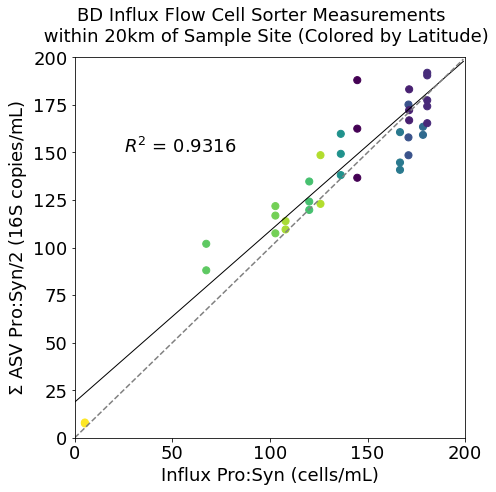

In [88]:
fontsize=18
size = 50
fig,ax = plt.subplots(1,1,figsize=(7,7))

x = np.arange(0,200)

BP_slope,BP_intercept,BP_r_value,BP_p_value,BP_std_err = stats.linregress(all_flow_cyt_pro_to_syn,A_pro_to_syn_IS_BP_for_flow_cyt)

ax.scatter(all_flow_cyt_pro_to_syn,A_pro_to_syn_IS_BP_for_flow_cyt,s=size,c=all_flow_cyt_lats)
ax.plot(x,BP_slope*x+BP_intercept,linewidth=1,c='k')
ax.text(25,150,'$R^2$ = %s'%(round(BP_r_value,4)),fontsize=fontsize)
ax.set_ylabel('$\Sigma$ ASV Pro:Syn/2 (16S copies/mL)',fontsize=fontsize)
ax.set_xlabel('Influx Pro:Syn (cells/mL)',fontsize=fontsize)

ax.plot(x,x,linestyle='--',c='gray')
ax.set_xlim([0,200])
ax.set_ylim([0,200])
ax.tick_params(axis='both', labelsize=fontsize)

plt.suptitle('BD Influx Flow Cell Sorter Measurements \n within 20km of Sample Site (Colored by Latitude)',fontsize=fontsize)   
plt.show()

### Plot Internal Standard Concentration

In [97]:
metadata

{'10B': ['20211120', '01:20', 30.1215, 238.4522],
 '10C': ['20211120', '01:20', 30.1215, 238.4522],
 '11A': ['20211120', '02:54', 29.9369, 238.1739],
 '11B': ['20211120', '02:54', 29.9369, 238.1739],
 '11C': ['20211120', '02:54', 29.9369, 238.1739],
 '13B': ['20211120', '04:52', 29.6959, 237.7231],
 '13C': ['20211120', '04:52', 29.6959, 237.7231],
 '14A': ['20211120', '06:54', 29.4512, 237.3091],
 '14B': ['20211120', '06:54', 29.4512, 237.3091],
 '14C': ['20211120', '06:54', 29.4512, 237.3091],
 '15B': ['20211120', '08:52', 29.2158, 236.8854],
 '15C': ['20211120', '08:52', 29.2158, 236.8854],
 '16A': ['20211120', '10:54', 29.0, 236.5574],
 '16B': ['20211120', '10:54', 29.0, 236.5574],
 '16C': ['20211120', '10:54', 29.0, 236.5574],
 '17B': ['20211120', '12:44', 28.739, 236.1088],
 '17C': ['20211120', '12:44', 28.739, 236.1088],
 '18B': ['20211120', '14:43', 28.503, 235.714],
 '18C': ['20211120', '14:43', 28.503, 235.714],
 '19B': ['20211121', '02:03', 28.2847, 235.3517],
 '19C': ['20211

In [98]:
xlabels,BP_prop_subset,DR_prop_subset,TT_prop_subset = [],[],[],[]
for key in metadata:
    xlabels.append(key)

    BP_prop_subset.append(BP_count[np.where([i==str(key) for i in np.array(header)])][0]/reads[key][2])
    DR_prop_subset.append(DR_count[np.where([i==str(key) for i in np.array(header)])][0]/reads[key][2])
    TT_prop_subset.append(TT_count[np.where([i==str(key) for i in np.array(header)])][0]/reads[key][2])

In [99]:
BP_prop_subset = np.array(BP_prop_subset)
DR_prop_subset = np.array(DR_prop_subset)
TT_prop_subset = np.array(TT_prop_subset)

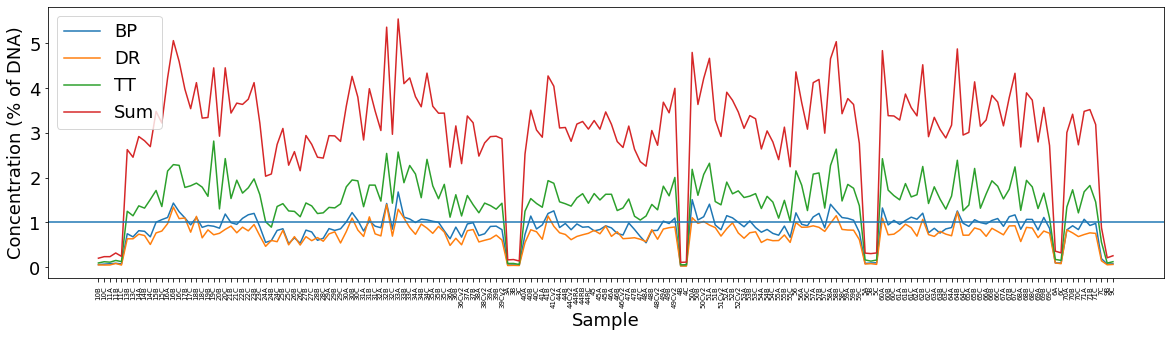

In [100]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(BP_prop_subset,label='BP')
ax.plot(DR_prop_subset,label='DR')
ax.plot(TT_prop_subset,label='TT')

#total_IS = []
#for i in np.arange(0,len(BP_prop_subset)):
#    total_IS.append(BP_prop_subset[i]+DR_prop_subset[i]+TT_prop_subset[i])
    
ax.plot(np.sum((BP_prop_subset,DR_prop_subset,TT_prop_subset),axis=0),label='Sum')
ax.axhline(1)

ax.set_xlabel('Sample',fontsize=fontsize)
ax.set_ylabel('Concentration (% of DNA)',fontsize=fontsize)

ax.set_xticks(np.arange(0,len(BP_prop_subset)))
ax.set_xticklabels(xlabels,fontsize=7,rotation=90)

#ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()

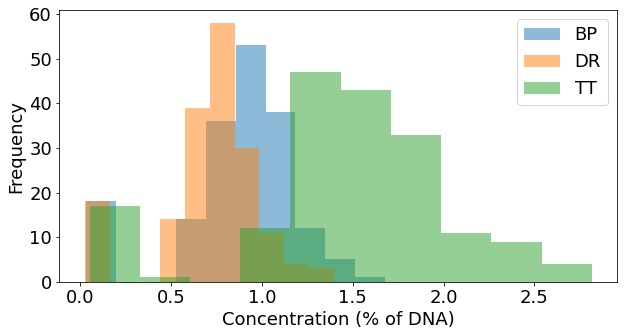

In [101]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.hist(BP_prop_subset,alpha=0.5,bins=10,label='BP')
ax.hist(DR_prop_subset,alpha=0.5,bins=10,label='DR')
ax.hist(TT_prop_subset,alpha=0.5,bins=10,label='TT')

ax.tick_params(axis='both', labelsize=fontsize)
ax.set_ylabel('Frequency',fontsize=fontsize)
ax.set_xlabel('Concentration (% of DNA)',fontsize=fontsize)

ax.legend(fontsize=fontsize)